In [44]:
import argparse
import os
import numpy as np
from datetime import datetime
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt
from torchvision import transforms as tfs

In [45]:
ROOT_DIR = "/data/typhon2/hattie/jwst/soss_simulations/unet_pytorch_training_data/"
SAVE_DIR = ROOT_DIR
# Load order zeros
order_zeros = np.load(os.path.join(ROOT_DIR, "train_contaminants.npy"))

In [46]:


class ConvBlock(nn.Module):
    """Convolutional block for UNet."""

    def __init__(
        self, in_channels, out_channels, kernel_size, use_batch_norm=True, dropout=0.05
    ):
        super(ConvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding="same")
        if self.use_batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)

        # He normal initialization
        nn.init.kaiming_normal_(self.conv.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        x = self.conv(x)
        if self.use_batch_norm:
            x = self.bn(x)
        x = self.relu(x)
        return x


class EncodingBlock(nn.Module):
    """Encoding block for UNet."""

    def __init__(
        self, in_channels, out_channels, kernel_size, use_batch_norm=True, dropout=0.05
    ):
        super(EncodingBlock, self).__init__()
        self.conv_block = ConvBlock(
            in_channels, out_channels, kernel_size, use_batch_norm, dropout
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(dropout)

    def forward(self, x):
        conv_out = self.conv_block(x)
        pooled = self.pool(conv_out)
        pooled = self.dropout(pooled)
        return conv_out, pooled


class DecodingBlock(nn.Module):
    """Decoding block for UNet."""

    def __init__(
        self,
        in_channels,
        concat_channels,
        out_channels,
        kernel_size,
        use_batch_norm=True,
        dropout=0.05,
    ):
        super(DecodingBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride=2, padding=1
        )
        self.dropout = nn.Dropout2d(dropout)
        self.conv_block = ConvBlock(
            out_channels + concat_channels,
            out_channels,
            kernel_size,
            use_batch_norm,
            dropout,
        )

    def forward(self, x, concat_tensor):
        x = self.upconv(x)

        # Handle size mismatch between upsampled and concat tensors
        if x.shape != concat_tensor.shape:
            x = F.interpolate(
                x, size=concat_tensor.shape[2:], mode="bilinear", align_corners=False
            )

        x = torch.cat([x, concat_tensor], dim=1)
        x = self.dropout(x)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    """UNet model for image segmentation."""

    def __init__(
        self,
        input_channels=1,
        filters=16,
        dropout=0.05,
        batch_normalisation=True,
        layers=4,
        output_activation="sigmoid",
        kernel_sizes=[(3, 5), (7, 5), (5, 3), (3, 5), (5, 15), (13, 3)],
    ):
        """
        Initialize the UNet model.

        Parameters
        ----------
        input_channels : int
            Number of input channels, default is 1.
        filters : int
            The number of filters to use in the convolutional layers, default is 16.
        dropout : float
            The dropout rate, default is 0.05.
        batch_normalisation : bool
            Whether to use batch normalisation, default is True.
        layers : int
            The number of encoding and decoding layers, default is 4.
        output_activation : str
            The activation function for the output layer, either "sigmoid", "softmax", or None.
        kernel_sizes : list
            List of kernel sizes for each layer.
        """
        super(UNet, self).__init__()

        self.filters = filters
        self.dropout = dropout
        self.batch_normalisation = batch_normalisation
        self.layers = len(kernel_sizes)
        self.output_activation = output_activation
        self.kernel_sizes = kernel_sizes

        # Encoding path
        self.encoding_blocks = nn.ModuleList()
        in_channels = input_channels

        for i, kernel_size in enumerate(kernel_sizes):
            out_channels = filters * (2**i)
            self.encoding_blocks.append(
                EncodingBlock(
                    in_channels, out_channels, kernel_size, batch_normalisation, dropout
                )
            )
            in_channels = out_channels

        # Latent space
        self.latent_conv = ConvBlock(
            in_channels,
            filters * (2**self.layers),
            kernel_sizes[-1],
            batch_normalisation,
            dropout,
        )

        # Decoding path
        self.decoding_blocks = nn.ModuleList()
        in_channels = filters * (2**self.layers)

        for i in reversed(range(len(kernel_sizes))):
            out_channels = filters * (2**i)
            concat_channels = out_channels  # Skip connection channels
            kernel_size = kernel_sizes[i]

            self.decoding_blocks.append(
                DecodingBlock(
                    in_channels,
                    concat_channels,
                    out_channels,
                    kernel_size,
                    batch_normalisation,
                    dropout,
                )
            )
            in_channels = out_channels

        # Output layer
        self.output_conv = nn.Conv2d(filters, 1, kernel_size=1)

        # Output activation
        if output_activation == "sigmoid":
            self.output_activation_fn = nn.Sigmoid()
        elif output_activation == "softmax":
            self.output_activation_fn = nn.Softmax(dim=1)
        else:
            self.output_activation_fn = None

    def forward(self, x):
        # Encoding path
        skip_connections = []
        current = x

        for encoding_block in self.encoding_blocks:
            skip_conn, current = encoding_block(current)
            skip_connections.append(skip_conn)

        # Latent space
        current = self.latent_conv(current)

        # Decoding path
        for i, decoding_block in enumerate(self.decoding_blocks):
            skip_idx = len(skip_connections) - 1 - i
            current = decoding_block(current, skip_connections[skip_idx])

        # Output
        output = self.output_conv(current)

        if self.output_activation_fn:
            output = self.output_activation_fn(output)

        # Apply absolute value (matching TF version)
        output = torch.abs(output)

        return output

# class CustomImageDataset(Dataset):
#     def __init__(self, imgs, transform=None, target_transform=None):
#         self.imgs = imgs
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.imgs)

#     def __getitem__(self, idx):
#         image = self.imgs[idx]

#         # Assuming AddContaminants.forward and PreprocessImage.forward
#         # both return (image, label)
#         if self.transform:
#             image, label = AddContaminants.forward(image)
#             image, label = PreprocessImage.forward(image, label)
#         else:
#             label = None  # or assign a default label if you have one

#         # Apply target_transform if provided
#         if self.target_transform:
#             label = self.target_transform(label)

#         return image, label
class CustomImageDataset(Dataset):
    # TODO: preprocess in data loader
    def __init__(self, imgs, transform=None, target_transform=None):
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        if self.transform:
            image, label = add_contaminants.forward(image)
            image, label = pre_process_image.forward(image, label)
        return image, label

class PreprocessImage(torch.nn.Module):
    def forward(self, img=None, label=None, normalise_max=300):

        if img is None:
            assert False
        if label is None:
            assert False

        data_max = torch.max(img)
        normalisation_factor = normalise_max / data_max
        img_normalised = img * normalisation_factor
        label_normalised = label * normalisation_factor

        return torch.log1p(img_normalised), torch.log1p(label_normalised)


class AddContaminants(torch.nn.Module):
    def forward(self, img=None, label=None, Jmag_range=(1, 16)):

        if img is None:
            assert False

        # # Add the random order 0s
        # print("within addContaminants")
        # print("img shape:", img.shape)
        # print("order0 shape:", order_zeros.shape)

        num_spectra, target_rows, target_cols = img.shape
        num_order0s, array_rows, array_cols = order_zeros.shape
        contam_list = []
        N_contaminants = random.randint(0,10)

        new_img = img
        new_label = torch.zeros(img.shape)

        for _ in range(N_contaminants):

            # Randomize the top-left position of the array of ones
            start_row = random.randint(-array_rows + 1, target_rows)
            start_col = random.randint(700, target_cols) # POM starts at col 700

            # Randomly choose a multiplication factor from the specified range
            factor = random.uniform(*Jmag_range)

            order_ = random.randint(0,num_order0s-1)

            contaminant = order_zeros[order_,:,:] * 1e4 # Scaling factor based on observations

            # Determine overlap region in the target array
            end_row = start_row + array_rows
            end_col = start_col + array_cols

            # Clip indices to be within the bounds of the target array
            target_start_row = max(start_row, 0)
            target_start_col = max(start_col, 0)
            target_end_row = min(end_row, target_rows)
            target_end_col = min(end_col, target_cols)

            # Determine the corresponding region of the array of ones
            array_start_row = max(0, -start_row)
            array_start_col = max(0, -start_col)
            array_end_row = array_start_row + (target_end_row - target_start_row)
            array_end_col = array_start_col + (target_end_col - target_start_col)

            new_img[:,target_start_row:target_end_row, target_start_col:target_end_col] += \
                factor * contaminant[array_start_row:array_end_row, array_start_col:array_end_col]
            
            new_label[:,target_start_row:target_end_row, target_start_col:target_end_col] += factor * contaminant[array_start_row:array_end_row, array_start_col:array_end_col]
            # print("end of loop")
        return new_img, new_label


class CustomCallback:
    """Custom callback for tracking training progress."""

    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, train_loss, val_loss):
        self.losses.append(train_loss)
        self.val_losses.append(val_loss)

        # Save losses
        logs_losses = {"loss": self.losses, "val_loss": self.val_losses}
        np.save(
            os.path.join(
                self.save_dir,
                "training_loss_varying_layers_2000_test_run_zeroth_scaled_1e7.npy",
            ),
            logs_losses,
        )

        # Plot losses
        fig, ax = plt.subplots(1, figsize=(5, 4))
        ax.plot(self.losses, label="training loss", color="#57d4c1", marker="None")
        ax.plot(
            self.val_losses, label="validation loss", color="#8d57d4", marker="None"
        )

        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()

        plt.savefig(os.path.join(self.save_dir, "training_loss_plot.png"))

        ax.set_yscale("log")
        plt.savefig(os.path.join(self.save_dir, "training_loss_plot_log.png"))

        plt.close()

In [47]:

add_contaminants = AddContaminants()
pre_process_image = PreprocessImage()

In [48]:

# Load data
data_train = np.load(os.path.join(ROOT_DIR, "clean_train.npy"))
data_train = data_train[:800, :, :]
data_validation = np.load(os.path.join(ROOT_DIR, "clean_validation.npy"))
data_validation = data_validation[:100, :, :]

print(f"Data train shape: {data_train.shape}")
print(f"Data validation shape: {data_validation.shape}")
print(f"Order zero array shape: {order_zeros.shape}")

Data train shape: (800, 256, 2048)
Data validation shape: (100, 256, 2048)
Order zero array shape: (6, 60, 60)


In [49]:
print(data_train.shape)
data_train = torch.FloatTensor(data_train).unsqueeze(-1) 
data_validation = torch.FloatTensor(data_validation).unsqueeze(-1)

print(data_train.shape)
# Convert numpy arrays to PyTorch tensors
data_train = torch.FloatTensor(data_train).permute(
    0, 3, 1, 2
)  # (N, H, W, C) -> (N, C, H, W)
data_validation = torch.FloatTensor(data_validation).permute(0, 3, 1, 2)
print(data_train.shape)

(800, 256, 2048)
torch.Size([800, 256, 2048, 1])
torch.Size([800, 1, 256, 2048])


In [50]:

transforms = tfs.Compose([
    tfs.ToTensor()

])
# Create datasets and dataloaders
train_dataset = CustomImageDataset(data_train, transform=transforms)
val_dataset = CustomImageDataset(data_validation, transform=transforms)

In [51]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: Tesla T4


In [52]:

def train_model(
    model, train_loader, val_loader, num_epochs=200, learning_rate=0.001, patience=10
):
    """Train the UNet model."""

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.1, patience=5, min_lr=0.00001
    )

    callback = CustomCallback(os.path.join(ROOT_DIR, SAVE_DIR))

    best_val_loss = float("inf")
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        mosaic = [["A","B"]]

        fig = plt.figure(figsize=(20, 5))  # set figure size here
        axes = fig.subplot_mosaic(mosaic)
        
        for batch_data, batch_labels in train_loader:
            print(batch_data.shape, batch_labels.shape)
            axes["A"].imshow(batch_data[0][0], aspect="auto", origin="lower")
            axes["B"].imshow(batch_labels[0][0], aspect="auto", origin="lower")
            plt.savefig("example_batch.png")


            assert False
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        avg_train_loss = train_loss / train_batches

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(
                    device
                )
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Custom callback
        callback.on_epoch_end(epoch, avg_train_loss, avg_val_loss)

        # Early stopping and model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            # Save best model
            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR, SAVE_DIR, "trained_model.pth"),
            )
            print(
                f"Epoch {epoch+1}: New best model saved with val_loss: {avg_val_loss:.6f}"
            )
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {avg_train_loss:.6f}, "
                f"Val Loss: {avg_val_loss:.6f}"
            )

    return {"loss": train_losses, "val_loss": val_losses}

In [55]:

batch_size = 8
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Create UNet model
unet_model = UNet(
    input_channels=1,
    filters=16,
    dropout=0.05,
    batch_normalisation=True,
    layers=6,
    output_activation=None,
    kernel_sizes=[(3, 5), (7, 5), (5, 3), (3, 5), (5, 15), (13, 3)],
)

print(
    f"Model parameters: {sum(p.numel() for p in unet_model.parameters() if p.requires_grad)}"
)

Model parameters: 90141329


torch.Size([8, 1, 256, 2048]) torch.Size([8, 1, 256, 2048])


AssertionError: 

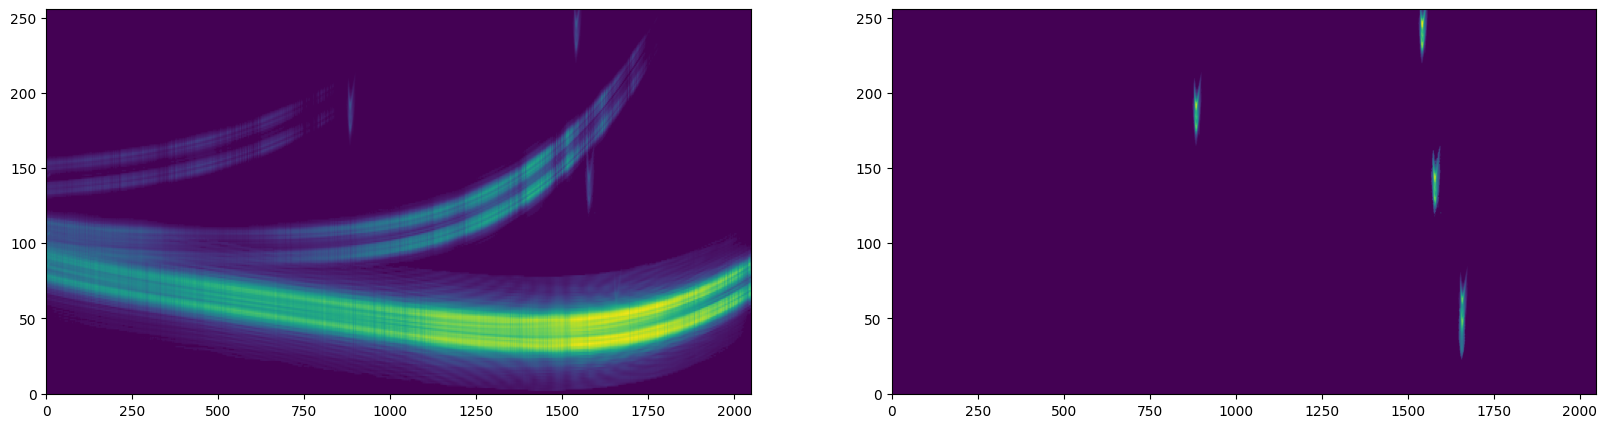

In [73]:
results = train_model(
    unet_model,
    train_loader,
    val_loader,
    num_epochs=100,
    learning_rate=0.001,
)